### VRPTW (2 índices) - modelo em "A generalized formulation for vehicle routing problem", pg. 3-5

In [1]:
# Importando as bibliotecas:

from docplex.mp.model import Model
from docplex.util.environment import get_environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# criando o modelo:

VRPTW_2 = Model(name='VRPTW_2')

In [2]:
# Rodando o programa com funções de ler instâncias e calcular distâncias entre nós:

%run utils

In [3]:
# obtendo instância e parâmetros iniciais:

# nome da instância:

instancia = 'R101'

# dataframe com os dados da instância e parâmetros específicos da instância:

df, parameters = VRPTW_instancia('instances\VRPTW\solomon25\{}.txt'.format(instancia))

# criando o nó artificial "n+1":

df.loc[len(df)] = list(df.copy().iloc[0])

# número de veículos disponíveis na instância

K = parameters['n_trucks']

# capacidade dos veículos da instância

Q = parameters['Q']

# demanda do cliente "i"

q = df['DEMAND']

# coordenadas do cliente "i"

coords = df[['XCOORD','YCOORD']]

# início da janela de tempo do cliente "i"

w_a = df['READY TIME']

# fim da janela de tempo do cliente "i"

w_b = df['DUE DATE']

# tempo de serviço para o cliente "i" (nessa instância, são iguais!)

s = df['SERVICE']

N = len(coords) # número de nós (considerando o depósito central!)

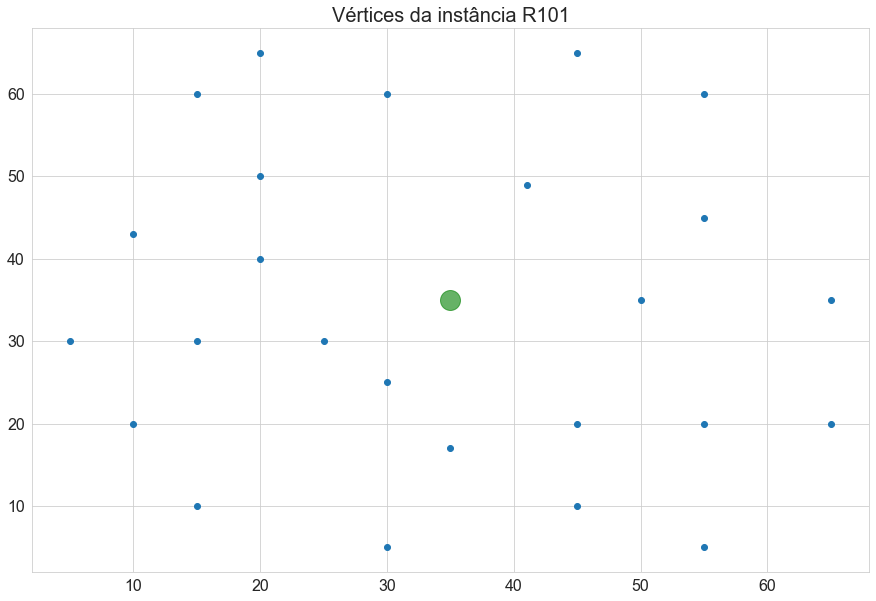

In [4]:
# Visualizando vértices da instância:

plt.figure(figsize=(15,10))

plt.scatter(x=df['XCOORD'].iloc[0],y=df['YCOORD'].iloc[0], color='green', s=400.0, alpha=0.6)

plt.scatter(x=df['XCOORD'].iloc[1:len(df)-1],y=df['YCOORD'].iloc[1:len(df)-1], alpha=1)

plt.title('Vértices da instância {}'.format(instancia), fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.show()

In [5]:
# atribuindo os custos de distância a uma variável "c", correspondente ao custo de descolamento do cliente "i" para o cliente "j"

c = np.round(np.matrix(matriz_2d_distancias('VRPTW',coords)), 1) # Truncado na primeira casa

t = c # uma vez que os veículos viajam a uma mesma distância e c = f(t) e t = f(d), pode-se considerar t igual a  c


#### Variáveis de decisão:

In [6]:
# variável binária x_{ij}, igual a 1 se há um veículo que viaja diretamente do cliente "i" para o cliente "j"

x = VRPTW_2.binary_var_matrix(range(N), range(N), name='x')

# variável contínua y_{j}, correspondente à demanda acumulada na rota que visita o nó "j"

y = VRPTW_2.continuous_var_list(range(N), name='y')

# variável contínua w_{i}, correspondente ao instante em que os serviços são iniciados no nó "i"

w = VRPTW_2.continuous_var_list(range(N), name = 'w')

## Modelo


#### Função objetivo

## $$ min \displaystyle \sum_{i = 0}^{n+1}\displaystyle \sum_{j=0}^{n+1}c_{ij}x_{ij}$$

In [7]:
# Armazenando a expressão para o custo total em uma variável:

custo_total = VRPTW_2.sum(c[i,j]*x[i,j] for i in range(N) for j in range(N))

VRPTW_2.minimize(custo_total)

#### Restrições

## $ (2.2) $ 
## $$\displaystyle \sum\limits_{\substack{j=1 \\ j\neq i}}^{n+1}x_{ij} = 1, \hspace{20 mm} i = 1, ... ,n $$


In [8]:
for i in range(1,N-1): 
    
    VRPTW_2.add_constraint(VRPTW_2.sum(x[i,j] for j in range(1,N) if i != j) == 1)
    
    # É necessário colocar o "i != j" dentro da definição da restrição porque, se colocado fora (após o loop),
    # teremos um j estático e, dessa forma, a restrição não será definida corretamente!


## $ (2.3) $ 
## $$ \sum\limits_{\substack{i=0 \\ i\neq h}}^{n}x_{ih} - \sum\limits_{\substack{j=1 \\ j\neq h}}^{n+1}x_{hj} = 0, \hspace{20 mm} h = 1, ... ,n $$



In [9]:
for h in range(1,N-1):
        
    VRPTW_2.add_constraint(VRPTW_2.sum(x[i,h] for i in range(0,N-1) if i != h) - VRPTW_2.sum(x[h,j] for j in range(1,N) if j != h) == 0)
        

## $ (2.4) $ 
## $$ \sum_{j=1}^{n}x_{0j} \leq K $$



In [10]:
VRPTW_2.add_constraint(VRPTW_2.sum(x[0,j] for j in range(1,N-1)) <= K)
    

docplex.mp.LinearConstraint[](x_0_1+x_0_2+x_0_3+x_0_4+x_0_5+x_0_6+x_0_7+x_0_8+x_0_9+x_0_10+x_0_11+x_0_12+x_0_13+x_0_14+x_0_15+x_0_16+x_0_17+x_0_18+x_0_19+x_0_20+x_0_21+x_0_22+x_0_23+x_0_24+x_0_25,LE,25)

## $ (2.5) $ 
## $$ y_{j} \geq y_{i} + q_{j}x_{ij} - Q(1-x_{ij}) \hspace{20 mm } i, j = 0, ..., n + 1 $$



In [11]:
for i in range(N):
    
    for j in range(N):
        
        VRPTW_2.add_constraint(y[j] >= y[i] + q[j]*x[i,j] - Q*(1-x[i,j]))

## $ (2.6) $ 
## $$ q_{i} \leq y_{i} \leq Q, \hspace{20 mm } i = 0, ..., n + 1 $$



In [12]:
for i in range(N):
    
    VRPTW_2.add_constraint(q[i] <= y[i])
    VRPTW_2.add_constraint(y[i] <= Q)

## $ (2.8) $ 
## $$ w_{j} \geq w_{i} + (s_{i}+t_{ij})x_{ij} - M_{ij}(1-x_{ij}),\hspace{20 mm } i = 0, ..., n; \hspace{4 mm } j = 1,..., n+1 $$



In [13]:
for i in range(N-1):
    
    for j in range(1,N):
        
        M_ij = max((w_b[i]-w_a[j]),0)
        
        VRPTW_2.add_constraint(w[j] >= w[i] + (s[i] + t[i,j])*x[i,j] - M_ij*(1-x[i,j]))

## $ (2.9) $ 
## $$ w_{i}^{a} \leq w_{i} \leq w_{i}^{b} ,\hspace{20 mm } i = 0, ..., n+1 $$



In [14]:
for i in range(N):
    
    VRPTW_2.add_constraint(w_a[i] <= w[i])
    VRPTW_2.add_constraint(w[i] <= w_b[i])

In [ ]:
#VRPTW_2.clear_constraints()

In [15]:
VRPTW_2.solve(log_output=True)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 2 times.
MIP Presolve eliminated 1463 rows and 541 columns.
MIP Presolve modified 902 coefficients.
Aggregator did 17 substitutions.
Reduced MIP has 84 rows, 219 columns, and 495 nonzeros.
Reduced MIP has 209 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (2.26 ticks)
Found incumbent of value 1173.600000 after 0.02 sec. (2.57 ticks)
Probing time = 0.02 sec. (0.33 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 31 rows and 9 columns.
MIP Presolve modified 18 coefficients.
Reduced MIP has 53 rows, 210 columns, and 421 nonzeros.
Reduced MIP has 206 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.46 ticks)
Probing time = 0.00 sec. (0.29 ticks)
Clique table members: 53.
MIP emphasis: balance optimality and feasibility.
MIP sea

docplex.mp.solution.SolveSolution(obj=618.1,values={x_0_2:1,x_0_5:1,x_0_..

In [16]:
# colocando todas as variáveis x em uma lista:

variaveis = [valor for valor in list(VRPTW_2.solution.as_df()['name']) if 'x' in valor] 

# obtendo listas com os arcos da rota ótima (tratando possíveis erros)

arcos = [list(map(int,variaveis[i].replace('x','').replace('_','\n').split())) for i in range(len(variaveis))]

arcos_iniciais = [arco for arco in arcos if arco[0] == 0]

lista_rotas = list()

for arco in arcos_iniciais:
    
    rota = [0]
    
    no_seguinte = arco[1]
    
    rota.append(no_seguinte)
    
    while no_seguinte != (N-1):
        
        no_seguinte = [arco[1] for arco in arcos if arco[0] == no_seguinte][0]
        
        rota.append(no_seguinte)
    
    lista_rotas.append(rota)

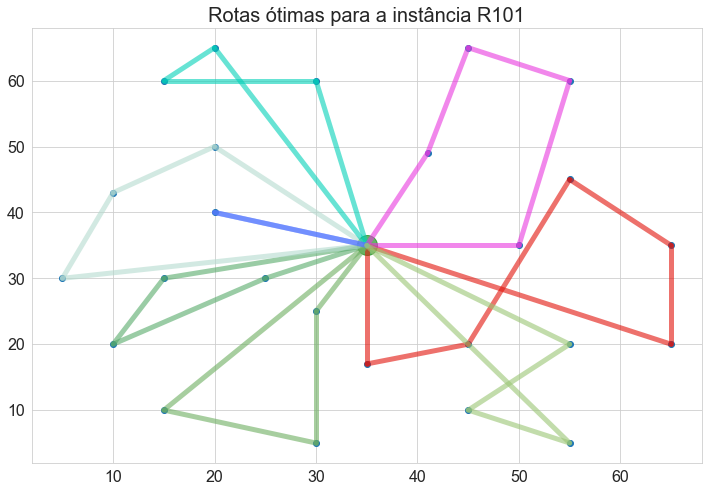

In [18]:
# Código para o plot

plt.figure(figsize=(12,8))

plt.scatter(x=df['XCOORD'].iloc[0],y=df['YCOORD'].iloc[0], color='green', s=400.0, alpha=0.6)

plt.scatter(x=df['XCOORD'].iloc[1:len(df)-1],y=df['YCOORD'].iloc[1:len(df)-1], alpha=1)


for rota in lista_rotas:
    
    cor = np.random.rand(3,)
    
    for index in range(len(rota) - 1):
        
        x_i = df['XCOORD'].iloc[rota[index]]

        x_j = df['XCOORD'].iloc[rota[index+1]]

        y_i = df['YCOORD'].iloc[rota[index]]

        y_j = df['YCOORD'].iloc[rota[index+1]]

        plt.plot((x_i,x_j),(y_i,y_j), c=cor, linewidth=5, alpha=0.6)
            

plt.title('Rotas ótimas para a instância {}'.format(instancia), fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.show()